### Module that utilizes Disease Classifier to obtain the relevant growth values from the dataset

In [6]:
import os
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms

from PIL import Image

import matplotlib.pyplot as plt
from tqdm import tqdm

import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if not torch.cuda.is_available(): print("WARNING: Model will run extremely slow on cpu")

In [2]:
import torch.nn.functional as F
from torchvision.models import resnet50, ResNet50_Weights

class ResNetClassifer(nn.Module):
    def __init  (self, num_classes):
        super(ResNetClassifer, self).  init__()
        self.num_classes = num_classes

        # Use a pre-trained ResNet model from Hugging Face
        self.resnet_model = resnet50(weights=ResNet50_Weights.DEFAULT)

        for param in self.resnet_model.parameters():
            param.requires_grad = False

        # Add a global average pooling layer
        self.global_avg_pooling = nn.AdaptiveAvgPool2d(1)

        # Fully connected layers for embedding
        fc_inputs = self.resnet_model.fc.in_features
        self.resnet_model.fc = nn.Sequential(
            nn.Linear(fc_inputs, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes), 
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        return self.resnet_model(x)

In [11]:
transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((224, 224), antialias=True),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize to [0, 1]
        ])

idx_to_class = {0: ('Apple', 'Apple Scab'),
                1: ('Apple', 'Black Rot'),
                2: ('Apple', 'Cedar Apple Rust'),
                3: ('Apple', 'Healthy'),
                4: ('Blueberry', 'Healthy'),
                5: ('Cherry', 'Healthy'),
                6: ('Cherry', 'Powdery Mildew'),
                7: ('Corn', 'Cercospora Leaf Spot / Gray Leaf Spot'),
                8: ('Corn', 'Common Rust'),
                9: ('Corn', 'Healthy'),
                10: ('Corn', 'Northern Leaf Blight'),
                11: ('Grape', 'Black Rot'),
                12: ('Grape', 'Esca (Black Measles)'),
                13: ('Grape', 'Healthy'),
                14: ('Grape', 'Leaf Blight (Isariopsis Leaf Spot)'),
                15: ('Orange', 'Haunglongbing (Citrus Greening)'),
                16: ('Peach', 'Bacterial Spot'),
                17: ('Peach', 'Healthy'),
                18: ('Bell Pepper', 'Bacterial Spot'),
                19: ('Bell Pepper', 'Healthy'),
                20: ('Potato', 'Early Blight'),
                21: ('Potato', 'Healthy'),
                22: ('Potato', 'Late Blight'),
                23: ('Raspberry', 'Healthy'),
                24: ('Soybean', 'Healthy'),
                25: ('Squash', 'Powdery Mildew'),
                26: ('Strawberry', 'Healthy'),
                27: ('Strawberry', 'Leaf Scorch'),
                28: ('Tomato', 'Bacterial Spot'),
                29: ('Tomato', 'Early Blight'),
                30: ('Tomato', 'Healthy'),
                31: ('Tomato', 'Late Blight'),
                32: ('Tomato', 'Leaf Mold'),
                33: ('Tomato', 'Septoria Leaf Spot'),
                34: ('Tomato', 'Spider Mites / Two-Spotted Spider Mite'),
                35: ('Tomato', 'Target Spot'),
                36: ('Tomato', 'Tomato Mosaic Virus'),
                37: ('Tomato', 'Tomato Yellow Leaf Curl Virus')}

In [4]:
# Load the model

DiseasePredictor = ResNetClassifer(len(idx_to_class.keys())).to(device)
if torch.cuda.is_available():
  DiseasePredictor.load_state_dict(torch.load("DiseasedCropClassifier_3epochs_firstIteration_92ValAcc.pth"))
else:
  print("WARNING: Model will run extremely slow on cpu. If on colab, go to Runtime->Change Runtime Type->Hardware Accelerator->GPU.")
  DiseasePredictor.load_state_dict(torch.load("/content/siamese_triplet_model_cache.pth", map_location=torch.device('cpu')))
DiseasePredictor.eval()

ResNetClassifer(
  (resnet_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequentia

### Import the csv dataset and pipe model output to obtain the relevant data

In [5]:
import pandas as pd

df = pd.read_csv("HackPrinceton Plant Data.csv")
df

,plant_name,temp_low,temp_high,humidity_low,humidity_high,sunlight,low_moisture_percent,high_moisture_percent
0,Apple,18,24,30,50,3,5,7
1,Blueberry,15,24,40,50,5,4,6
2,Cherry,18,24,40,60,4,5,7
3,Corn,21,32,40,60,5,6,8
4,Grape,15,32,30,50,5,5,7
5,Orange,21,32,40,60,5,6,8
6,Peach,18,27,30,50,4,6,8
7,Pepper,21,29,40,60,4,6,8
8,Potato,15,20,80,90,4,5,7
9,Rasberry,18,24,50,60,3,4,6


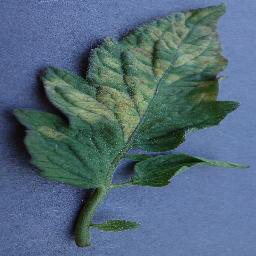

Plant Type:  Tomato
Disease Status:  Leaf Mold
Confidence in Disease Assesment: 93.354648%


In [21]:
# Now, let's import an image as if we just received it from the arduino

img_path = 'D:/Rutgers/ExtraProjects/HackPrinceton23/HackPrinceton23/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid/Tomato___Leaf_Mold/1fef5c8b-7d83-45b5-9031-f636c3dc44ae___Crnl_L.Mold 8953.JPG'

# Open the image
img = Image.open(img_path).convert("RGB")
display(img)
img = transform(img)

prediction = DiseasePredictor(img.to(device).unsqueeze(0))
probabilities = F.softmax(prediction, dim=1)
predicted_probability, predicted_classes = probabilities.max(1)
predicted_classes = predicted_classes.item()
plant_type, disease_status = idx_to_class[predicted_classes]
predicted_probability = predicted_probability.item()*100

print("Plant Type: ", plant_type)
print("Disease Status: ", disease_status)
print(f'Confidence in Disease Assesment: {predicted_probability:.6f}%')

In [17]:
df[df['plant_name'] == plant_type]

,plant_name,temp_low,temp_high,humidity_low,humidity_high,sunlight,low_moisture_percent,high_moisture_percent
13,Tomato,21,29,40,70,5,6,8
